## Preprocess

In [1]:
file = open("./data/war&peace.txt","r",encoding="utf-8")
data=file.read()

In [2]:
data = data.lower()
data = data.replace("\n"," ")

In [26]:
max_features = 100  # Number of words for vocab 
n_char = 25 # Number of char as input to model
embedding_dim = 50 # Embedding vector dimension

## Tokenization

In [4]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features,lower=False,filters="",char_level=True)

In [5]:
tokenizer.fit_on_texts([data])

In [6]:
data_encoded = tokenizer.texts_to_sequences([data])[0]

In [7]:
vocab_size = len(tokenizer.word_index)+1
print(f"Vocabluary size: {vocab_size}")

Vocabluary size: 66


## Model Input&Output

In [8]:
X = []
y = []
for i in range(n_char, len(data_encoded)):
    X.append(data_encoded[i-n_char:i])
    y.append(data_encoded[i])

In [9]:
import numpy as np
from keras.utils import to_categorical
X = np.array(X)
y = np.array(y)

## Embedding

In [10]:
# pretrained GloVe embedding 6B tokens, 400K vocab size  50d vectors
# source https://nlp.stanford.edu/projects/glove/
embedding = open("embeddings/glove.6B.50d.txt",encoding="utf-8")

In [11]:
#Creating embedding dictionary
embedding_dict= {}
for i in embedding:
    line = i.split(' ')
    line[-1]=line[-1].replace('\n','')
    embedding_dict[''+line[0]]=line[1:]

In [12]:
len(embedding_dict)

400000

In [13]:
keys = embedding_dict.keys()
unk_token = np.zeros(embedding_dim,)
#Using unk_token(average of all vetors) for the words not in embedding ectors
for i in keys:
    unk_token = unk_token + np.array(embedding_dict[i],float)
unk_token = unk_token / len(keys)

In [82]:
# creating embedding matrix
counter = 0
unk_chars = []
embedding_matrix = np.zeros((vocab_size, embedding_dim))
embedding_matrix[0] = np.zeros(embedding_dim,)
for word, i in tokenizer.word_index.items():
    if i == vocab_size:
        break
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is  None:
        #words not in embedding considered unk token
        embedding_vector = unk_token.tolist()
        counter = counter + 1
        unk_chars.append(word)
    embedding_matrix[i] = embedding_vector

In [15]:
embedding_matrix.shape

(66, 50)

In [16]:
print(f"Number of unk token usage: {counter}")

Number of unk token usage: 1


In [83]:
# whitespace character was not in embedding
unk_chars

[' ']

## Model

In [17]:
from keras.models import Sequential
from keras.layers import LSTM,RNN,Dense,Embedding,Input,Flatten
model = Sequential()
# training embedding vectors this time
model.add(Embedding(input_dim = vocab_size , weights =[embedding_matrix], output_dim = embedding_dim, input_length = n_char, trainable=True))
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(64))
model.add(Dense(128,activation = "relu"))
model.add(Dense(64,activation = "relu"))
model.add(Flatten())
model.add(Dense(vocab_size, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            3300      
_________________________________________________________________
lstm (LSTM)                  (None, 25, 128)           91648     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 66)                4

# Compile&Train

In [19]:
# call back for stop training at certein accuracy threshold
from keras.callbacks import Callback,ModelCheckpoint
class My_Callback(Callback):
    def __init__(self, threshold,model_save_cp):
        super(My_Callback, self).__init__()
        self.threshold = threshold
        self.model_save_cp = model_save_cp
    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["sparse_categorical_accuracy"]
        if (epoch+1) % self.model_save_cp == 0:
            print(f"\nModel Checkpoint reached saving model weights...\n")
            self.model.save_weights(f"model/en-lang-model-{epoch+1}ep.h5")
        if acc >= self.threshold:
            print(f"Accuracy reach over {self.threshold}% terminating train process.")
            self.model.save_weights(f"model/en-lang-model-{epoch}ep.h5")
            self.model.stop_training = True
            

In [20]:
#categorical_accuracy
cb = My_Callback(threshold = 0.85, model_save_cp = 400)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
history = model.fit(X, y, batch_size=4096, epochs=2000, callbacks=[cb])

Epoch 1/2000
67/67 [==============================] - 10s 88ms/step - loss: 3.5219 - sparse_categorical_accuracy: 0.1376
Epoch 2/2000
67/67 [==============================] - 6s 88ms/step - loss: 2.8343 - sparse_categorical_accuracy: 0.2178
Epoch 3/2000
67/67 [==============================] - 6s 88ms/step - loss: 2.5121 - sparse_categorical_accuracy: 0.3000
Epoch 4/2000
67/67 [==============================] - 6s 88ms/step - loss: 2.3647 - sparse_categorical_accuracy: 0.3197
Epoch 5/2000
67/67 [==============================] - 6s 88ms/step - loss: 2.2580 - sparse_categorical_accuracy: 0.3429
Epoch 6/2000
67/67 [==============================] - 6s 88ms/step - loss: 2.1783 - sparse_categorical_accuracy: 0.3623
Epoch 7/2000
67/67 [==============================] - 6s 88ms/step - loss: 2.1108 - sparse_categorical_accuracy: 0.3829
Epoch 8/2000
67/67 [==============================] - 6s 88ms/step - loss: 2.0652 - sparse_categorical_accuracy: 0.3991
Epoch 9/2000
67/67 [===================

67/67 [==============================] - 6s 88ms/step - loss: 1.3050 - sparse_categorical_accuracy: 0.6048
Epoch 68/2000
67/67 [==============================] - 6s 90ms/step - loss: 1.3077 - sparse_categorical_accuracy: 0.6049
Epoch 69/2000
67/67 [==============================] - 6s 89ms/step - loss: 1.2987 - sparse_categorical_accuracy: 0.6057: 1s - loss: 1.2980 - sparse_categorical
Epoch 70/2000
67/67 [==============================] - 6s 89ms/step - loss: 1.2978 - sparse_categorical_accuracy: 0.6080
Epoch 71/2000
67/67 [==============================] - 6s 90ms/step - loss: 1.2949 - sparse_categorical_accuracy: 0.6082
Epoch 72/2000
67/67 [==============================] - 6s 89ms/step - loss: 1.2901 - sparse_categorical_accuracy: 0.6092
Epoch 73/2000
67/67 [==============================] - 6s 88ms/step - loss: 1.2866 - sparse_categorical_accuracy: 0.6096
Epoch 74/2000
67/67 [==============================] - 6s 88ms/step - loss: 1.2834 - sparse_categorical_accuracy: 0.6115
Epoch 

67/67 [==============================] - 6s 89ms/step - loss: 1.1116 - sparse_categorical_accuracy: 0.6570
Epoch 134/2000
67/67 [==============================] - 6s 89ms/step - loss: 1.1032 - sparse_categorical_accuracy: 0.6613
Epoch 135/2000
67/67 [==============================] - 6s 89ms/step - loss: 1.1073 - sparse_categorical_accuracy: 0.6587
Epoch 136/2000
67/67 [==============================] - 6s 89ms/step - loss: 1.1031 - sparse_categorical_accuracy: 0.6591
Epoch 137/2000
67/67 [==============================] - 6s 90ms/step - loss: 1.1043 - sparse_categorical_accuracy: 0.6593
Epoch 138/2000
67/67 [==============================] - 6s 90ms/step - loss: 1.1009 - sparse_categorical_accuracy: 0.6614
Epoch 139/2000
67/67 [==============================] - 6s 90ms/step - loss: 1.1062 - sparse_categorical_accuracy: 0.6593
Epoch 140/2000
67/67 [==============================] - 6s 89ms/step - loss: 1.0987 - sparse_categorical_accuracy: 0.6604
Epoch 141/2000
67/67 [=================

67/67 [==============================] - 6s 87ms/step - loss: 0.9789 - sparse_categorical_accuracy: 0.6949
Epoch 200/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.9822 - sparse_categorical_accuracy: 0.6947
Epoch 201/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.9788 - sparse_categorical_accuracy: 0.6956
Epoch 202/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.9761 - sparse_categorical_accuracy: 0.6970
Epoch 203/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.9760 - sparse_categorical_accuracy: 0.6964
Epoch 204/2000
67/67 [==============================] - 6s 86ms/step - loss: 0.9740 - sparse_categorical_accuracy: 0.6984
Epoch 205/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.9746 - sparse_categorical_accuracy: 0.6972
Epoch 206/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.9769 - sparse_categorical_accuracy: 0.6960
Epoch 207/2000
67/67 [=================

67/67 [==============================] - 6s 92ms/step - loss: 0.8862 - sparse_categorical_accuracy: 0.7252
Epoch 265/2000
67/67 [==============================] - 6s 92ms/step - loss: 0.8787 - sparse_categorical_accuracy: 0.7269
Epoch 266/2000
67/67 [==============================] - 6s 92ms/step - loss: 0.8812 - sparse_categorical_accuracy: 0.7261
Epoch 267/2000
67/67 [==============================] - 6s 92ms/step - loss: 0.8854 - sparse_categorical_accuracy: 0.7253
Epoch 268/2000
67/67 [==============================] - 6s 91ms/step - loss: 0.8807 - sparse_categorical_accuracy: 0.7270
Epoch 269/2000
67/67 [==============================] - 6s 91ms/step - loss: 0.8810 - sparse_categorical_accuracy: 0.7259: 1s - loss: 0.8797 - sparse_categor
Epoch 270/2000
67/67 [==============================] - 6s 92ms/step - loss: 0.8821 - sparse_categorical_accuracy: 0.7246
Epoch 271/2000
67/67 [==============================] - 6s 92ms/step - loss: 0.8781 - sparse_categorical_accuracy: 0.7264
Epo

67/67 [==============================] - 6s 88ms/step - loss: 0.8098 - sparse_categorical_accuracy: 0.7480
Epoch 331/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.8071 - sparse_categorical_accuracy: 0.7481: 2s - loss: 0.8031 - sparse_ca
Epoch 332/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.8122 - sparse_categorical_accuracy: 0.7479: 1s - loss: 0.8117 - sparse_catego
Epoch 333/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.8095 - sparse_categorical_accuracy: 0.7476
Epoch 334/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.8123 - sparse_categorical_accuracy: 0.7486
Epoch 335/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.8077 - sparse_categorical_accuracy: 0.7477
Epoch 336/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.8106 - sparse_categorical_accuracy: 0.7475
Epoch 337/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.8093 - sparse_ca

67/67 [==============================] - 6s 88ms/step - loss: 0.7665 - sparse_categorical_accuracy: 0.7608
Epoch 397/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.7531 - sparse_categorical_accuracy: 0.7650
Epoch 398/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.7505 - sparse_categorical_accuracy: 0.7660
Epoch 399/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.7535 - sparse_categorical_accuracy: 0.7664
Epoch 400/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.7511 - sparse_categorical_accuracy: 0.7666: 2s - loss: 0.7495 - sp

Model Checkpoint reached saving model weights...

Epoch 401/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.7545 - sparse_categorical_accuracy: 0.7656
Epoch 402/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.7493 - sparse_categorical_accuracy: 0.7673
Epoch 403/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.7450 - 

67/67 [==============================] - 6s 88ms/step - loss: 0.7134 - sparse_categorical_accuracy: 0.7767
Epoch 463/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.7100 - sparse_categorical_accuracy: 0.7786
Epoch 464/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.7075 - sparse_categorical_accuracy: 0.7794
Epoch 465/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.7088 - sparse_categorical_accuracy: 0.7794
Epoch 466/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.7101 - sparse_categorical_accuracy: 0.7777
Epoch 467/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6998 - sparse_categorical_accuracy: 0.7820
Epoch 468/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.7041 - sparse_categorical_accuracy: 0.7806
Epoch 469/2000
67/67 [==============================] - 6s 90ms/step - loss: 0.7022 - sparse_categorical_accuracy: 0.7806
Epoch 470/2000
67/67 [=================

67/67 [==============================] - 6s 88ms/step - loss: 0.6740 - sparse_categorical_accuracy: 0.7892
Epoch 528/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.7818
Epoch 529/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6796 - sparse_categorical_accuracy: 0.7862
Epoch 530/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6655 - sparse_categorical_accuracy: 0.7921
Epoch 531/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6693 - sparse_categorical_accuracy: 0.7915
Epoch 532/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6732 - sparse_categorical_accuracy: 0.7893
Epoch 533/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6714 - sparse_categorical_accuracy: 0.7900
Epoch 534/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6695 - sparse_categorical_accuracy: 0.7910
Epoch 535/2000
67/67 [=================

67/67 [==============================] - 6s 89ms/step - loss: 0.6356 - sparse_categorical_accuracy: 0.8008: 0s - loss: 0.6350 - sparse_categorical_accuracy: 0.
Epoch 594/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6430 - sparse_categorical_accuracy: 0.7994
Epoch 595/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.7980
Epoch 596/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.7973
Epoch 597/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6469 - sparse_categorical_accuracy: 0.7984
Epoch 598/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6508 - sparse_categorical_accuracy: 0.7950
Epoch 599/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.7988
Epoch 600/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6387 - sparse_categorical_acc

Epoch 659/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6385 - sparse_categorical_accuracy: 0.7985
Epoch 660/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6586 - sparse_categorical_accuracy: 0.7917
Epoch 661/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6352 - sparse_categorical_accuracy: 0.7987
Epoch 662/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.8001
Epoch 663/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6166 - sparse_categorical_accuracy: 0.8066
Epoch 664/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6161 - sparse_categorical_accuracy: 0.8070
Epoch 665/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6120 - sparse_categorical_accuracy: 0.8082
Epoch 666/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6128 - sparse_categorical_accuracy: 0.8090
Epoch 667/2000
67/67 [==

67/67 [==============================] - 6s 88ms/step - loss: 0.6002 - sparse_categorical_accuracy: 0.8115
Epoch 726/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5983 - sparse_categorical_accuracy: 0.8124
Epoch 727/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6017 - sparse_categorical_accuracy: 0.8113
Epoch 728/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5942 - sparse_categorical_accuracy: 0.8146
Epoch 729/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6020 - sparse_categorical_accuracy: 0.8109
Epoch 730/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6029 - sparse_categorical_accuracy: 0.8099
Epoch 731/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6094 - sparse_categorical_accuracy: 0.8083
Epoch 732/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.6044 - sparse_categorical_accuracy: 0.8101
Epoch 733/2000
67/67 [=================

67/67 [==============================] - 6s 88ms/step - loss: 0.5845 - sparse_categorical_accuracy: 0.8162
Epoch 792/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5855 - sparse_categorical_accuracy: 0.8155
Epoch 793/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5853 - sparse_categorical_accuracy: 0.8163
Epoch 794/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5821 - sparse_categorical_accuracy: 0.8172
Epoch 795/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5830 - sparse_categorical_accuracy: 0.8157
Epoch 796/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5849 - sparse_categorical_accuracy: 0.8159
Epoch 797/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5999 - sparse_categorical_accuracy: 0.8097
Epoch 798/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.6067 - sparse_categorical_accuracy: 0.8076
Epoch 799/2000
67/67 [=================

67/67 [==============================] - 6s 89ms/step - loss: 0.5751 - sparse_categorical_accuracy: 0.8185
Epoch 858/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5696 - sparse_categorical_accuracy: 0.8209: 0s - loss: 0.5692 - sparse_categorical_accuracy: 
Epoch 859/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5796 - sparse_categorical_accuracy: 0.8177
Epoch 860/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5739 - sparse_categorical_accuracy: 0.8191
Epoch 861/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5716 - sparse_categorical_accuracy: 0.8193
Epoch 862/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6009 - sparse_categorical_accuracy: 0.8102
Epoch 863/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5727 - sparse_categorical_accuracy: 0.8204
Epoch 864/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5718 - sparse_categorical_accur

67/67 [==============================] - 6s 88ms/step - loss: 0.5520 - sparse_categorical_accuracy: 0.8263: 1s - loss: 0.5509 - sparse_categori
Epoch 923/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5561 - sparse_categorical_accuracy: 0.8255
Epoch 924/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5487 - sparse_categorical_accuracy: 0.8265
Epoch 925/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5529 - sparse_categorical_accuracy: 0.8258
Epoch 926/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5636 - sparse_categorical_accuracy: 0.8222
Epoch 927/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5603 - sparse_categorical_accuracy: 0.8228
Epoch 928/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5657 - sparse_categorical_accuracy: 0.8207
Epoch 929/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5727 - sparse_categorical_accuracy: 0.8184
Ep

67/67 [==============================] - 6s 89ms/step - loss: 0.5319 - sparse_categorical_accuracy: 0.8332
Epoch 987/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5341 - sparse_categorical_accuracy: 0.8323
Epoch 988/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5353 - sparse_categorical_accuracy: 0.8323
Epoch 989/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5455 - sparse_categorical_accuracy: 0.8276
Epoch 990/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5536 - sparse_categorical_accuracy: 0.8256
Epoch 991/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5579 - sparse_categorical_accuracy: 0.8236: 3s - loss: 0.5529 - sparse_categorical_accuracy: - ETA: 2s - loss: 0.5544 - spa
Epoch 992/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5661 - sparse_categorical_accuracy: 0.8197
Epoch 993/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5

67/67 [==============================] - 6s 88ms/step - loss: 0.5271 - sparse_categorical_accuracy: 0.8338
Epoch 1052/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5397 - sparse_categorical_accuracy: 0.8307
Epoch 1053/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5422 - sparse_categorical_accuracy: 0.8272
Epoch 1054/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5545 - sparse_categorical_accuracy: 0.8235
Epoch 1055/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5503 - sparse_categorical_accuracy: 0.8247
Epoch 1056/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5556 - sparse_categorical_accuracy: 0.8240
Epoch 1057/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5386 - sparse_categorical_accuracy: 0.8285: 4s - loss:
Epoch 1058/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5310 - sparse_categorical_accuracy: 0.8319
Epoch 1059/2000
67/6

67/67 [==============================] - 6s 89ms/step - loss: 0.5130 - sparse_categorical_accuracy: 0.8392
Epoch 1117/2000
67/67 [==============================] - 6s 90ms/step - loss: 0.5110 - sparse_categorical_accuracy: 0.8397
Epoch 1118/2000
67/67 [==============================] - 6s 90ms/step - loss: 0.5303 - sparse_categorical_accuracy: 0.8328
Epoch 1119/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5427 - sparse_categorical_accuracy: 0.8286
Epoch 1120/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5305 - sparse_categorical_accuracy: 0.8321
Epoch 1121/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5284 - sparse_categorical_accuracy: 0.8327: 1s - loss: 0.5263 - sparse_categorical_ac
Epoch 1122/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5323 - sparse_categorical_accuracy: 0.8325
Epoch 1123/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5237 - sparse_categorical_accura

67/67 [==============================] - 6s 87ms/step - loss: 0.5185 - sparse_categorical_accuracy: 0.8346
Epoch 1183/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5352 - sparse_categorical_accuracy: 0.8305
Epoch 1184/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5232 - sparse_categorical_accuracy: 0.8348
Epoch 1185/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5151 - sparse_categorical_accuracy: 0.8374
Epoch 1186/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5276 - sparse_categorical_accuracy: 0.8326
Epoch 1187/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5250 - sparse_categorical_accuracy: 0.8343
Epoch 1188/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5176 - sparse_categorical_accuracy: 0.8371
Epoch 1189/2000
67/67 [==============================] - 6s 87ms/step - loss: 0.5210 - sparse_categorical_accuracy: 0.8355
Epoch 1190/2000
67/67 [=========

67/67 [==============================] - 6s 88ms/step - loss: 0.5228 - sparse_categorical_accuracy: 0.8340
Epoch 1248/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5236 - sparse_categorical_accuracy: 0.8334: 3s - loss: 0
Epoch 1249/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5139 - sparse_categorical_accuracy: 0.8371
Epoch 1250/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5033 - sparse_categorical_accuracy: 0.8418: 1s - loss: 0.5028 - sparse_categoric
Epoch 1251/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.4926 - sparse_categorical_accuracy: 0.8453
Epoch 1252/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.4916 - sparse_categorical_accuracy: 0.8465
Epoch 1253/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.4954 - sparse_categorical_accuracy: 0.8451
Epoch 1254/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.4966 - sparse_categoric

67/67 [==============================] - 6s 88ms/step - loss: 0.4992 - sparse_categorical_accuracy: 0.8418
Epoch 1311/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.4976 - sparse_categorical_accuracy: 0.8433: 2s - loss: 0.4952 - spa
Epoch 1312/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5048 - sparse_categorical_accuracy: 0.8417
Epoch 1313/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5063 - sparse_categorical_accuracy: 0.8402
Epoch 1314/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.4998 - sparse_categorical_accuracy: 0.8414
Epoch 1315/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5020 - sparse_categorical_accuracy: 0.8404: 3s - loss: 0.
Epoch 1316/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.6063 - sparse_categorical_accuracy: 0.8107
Epoch 1317/2000
67/67 [==============================] - 6s 89ms/step - loss: 0.5879 - sparse_categorical_accuracy:

67/67 [==============================] - 6s 88ms/step - loss: 0.4909 - sparse_categorical_accuracy: 0.8456
Epoch 1376/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.4818 - sparse_categorical_accuracy: 0.8494
Epoch 1377/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.4914 - sparse_categorical_accuracy: 0.8442
Epoch 1378/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.4941 - sparse_categorical_accuracy: 0.8435
Epoch 1379/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5130 - sparse_categorical_accuracy: 0.8374
Epoch 1380/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5191 - sparse_categorical_accuracy: 0.8335
Epoch 1381/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5016 - sparse_categorical_accuracy: 0.8408
Epoch 1382/2000
67/67 [==============================] - 6s 88ms/step - loss: 0.5004 - sparse_categorical_accuracy: 0.8410
Epoch 1383/2000
67/67 [=========

## Evaluation 

In [32]:
model.evaluate(X,y)

8487/8487 [==============================] - 47s 5ms/step - loss: 0.4594 - sparse_categorical_accuracy: 0.8580


[0.45939257740974426, 0.858049750328064]

In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['sparse_categorical_accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.title('Training  accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'r', label='Training loss')
    plt.title('Training loss')
    plt.legend()

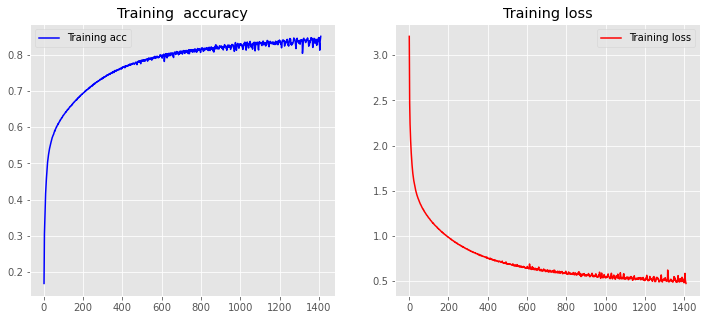

In [22]:
plot_history(history)

To generate sequence basically get seed text and and consider 25 character right side and ignore others, if its less than 25 character padding(pre) from left side after that for each 25 character model predict 1 character. After prediction we feed 24 word from previous input and previously predicted charatcter as 5th charatcter and so on.

In [80]:
# for dynamic printing
from IPython.display import display, clear_output
# padding for fixed input size
from keras.preprocessing.sequence import pad_sequences
# generating sequence from language model
def generate_sequence(tokenizer, max_output_seq_len, n_input_chars, seed_text, model,stream = True):
    model_input = seed_text.lower()
    
    # generate given max amount of word
    for _ in range(max_output_seq_len):
        # tokenize input text
        model_input_encoded = tokenizer.texts_to_sequences([model_input])[0]
        # pre-padding for fixed length(n_input_chars)
        model_input_encoded = pad_sequences([model_input_encoded], maxlen=n_input_chars, padding='pre')
        # predict probabilties for each char in vocab.
        prediction = model.predict(model_input_encoded)[0]
        prediction = np.argmax(prediction)
        # finding predicted char
        predicted_word = list(tokenizer.word_index.keys())[prediction-1]
        model_input = model_input  + predicted_word
        if stream:
            display(model_input)
            clear_output(wait=True)
    if ~stream:
        print(model_input)

In [64]:
# for dynamic printing
from IPython.display import display, clear_output
# padding for fixed input size
from keras.preprocessing.sequence import pad_sequences
# generating sequence from language model
def generate_sequence_with_random_choice(tokenizer, max_output_seq_len, n_input_chars, seed_text, model, acceptance_threshold,stream = True):
    model_input = seed_text.lower()
    
    # generate given max amount of word
    for _ in range(max_output_seq_len):
        # variable countermeasure if threshold too high for prediction
        at = acceptance_threshold
        # tokenize input text
        model_input_encoded = tokenizer.texts_to_sequences([model_input])[0]
        # pre-padding for fixed length(n_input_chars)
        model_input_encoded = pad_sequences([model_input_encoded], maxlen=n_input_chars, padding='pre')
        # predict probabilties for each char in vocab.
        prediction = model.predict(model_input_encoded)
        # countermeasure if threshold too high for prediction
        if np.max(prediction) < acceptance_threshold:
            at = np.max(prediction)
        # take predicted chars with probability higher than the threshold
        prediction = prediction >= at
        # taking index high prob. words(true values)
        possible_words = np.where(prediction)[1]
        # choosing one of possible word
        choosen_index = possible_words[np.random.randint(0,len(possible_words))]
        # getting correspanding key from word index
        predicted_word = list(tokenizer.word_index.keys())[choosen_index-1]
        model_input = model_input + predicted_word
        if stream:
            display(model_input)
            clear_output(wait=True)
    if ~stream:
        print(model_input)

In [78]:
generate_sequence(tokenizer, 250, n_char, "Nicholas looked the sky", model)

nicholas looked the skypteass selly to the open discussed to see him to spe-caper to the guardsworving sil! managed that in the elders bearing step in all the service trest delightfub surcapteredly rounds and seated a momently togied her when the story of generable, and, ttest2


In [68]:
generate_sequence_with_random_choice(tokenizer, 250, n_char, "Nicholas looked the sky", model,acceptance_threshold = 0.4)

nicholas looked the skypteass selly to the other table were all are three stheek, who...”  hearing and stavonate affection that knows why the oung canfors. believe out heavens. they wording that she shoohstásson stucked the day were strait a conseffids to the anoticked his


In [29]:
generate_sequence(tokenizer, 150, n_char, "She suddenly", model)

'She suddenly shrugged you and perhaps the afloner, and at the ambassa,” asked the enelle perhaged almost implow to say, here again with a singy, wran as he was en'

In [30]:
generate_sequence_with_random_choice(tokenizer, 150, n_char, "She suddenly ", model,acceptance_threshold = 0.5)

'She suddenly shrugged you and perhaps the afloner, and at the ambassa,” asked the enelle perhaged almost implow to say, here again with a singy, wran as he was ent'

In [31]:
generate_sequence(tokenizer, 50, n_char, "The Italian seemed happy", model)

'The Italian seemed happy! along they wish to this stoes of thinary the cha'

## Lets compare models at checkpoints(per400 epoch)

In [ ]:
ep_list = [400,800,1200,1408]
seed_test = "Prince Hippolyte hurriedly put on his cloak,"
for ep in ep_list:
    model.load_weights(f"model/en-lang-model-{ep}ep.h5")
    print(f"\n-------Output for model at {ep} epoch-------\nSeed Text : \"{seed_test}\"\n")
    generate_sequence(tokenizer, 250, n_char, seed_test, model,stream = False)


-------Output for model at 400 epoch-------
Seed Text : "Prince Hippolyte hurriedly put on his cloak,"

prince hippolyte hurriedly put on his cloak, so rapid how he was a great, touching on the priests of men was spreasure the conservatory to the princess was a sceam of all the row on his sheress of the sight of madameonessed the moment our man was silently at her wishes with your way to the cou

-------Output for model at 800 epoch-------
Seed Text : "Prince Hippolyte hurriedly put on his cloak,"

prince hippolyte hurriedly put on his cloak, shook inamievelf animatied make a sign of anna pávlovna’,’’ expadinges he profully or the pose of the soverion.  “you shall be only mellow, in moscow and smiling it all their manners “along the pooper’s commender than her son’s’imy bele betwetchs ou

-------Output for model at 1200 epoch-------
Seed Text : "Prince Hippolyte hurriedly put on his cloak,"

